# Convolutional networks for image classification

Here we'll use VGG16 as a base to train a state of the art classifier which will tell dogs from cats...

In [1]:
%matplotlib inline

In [116]:
from keras.applications.vgg16 import VGG16
from keras.layers.core import Dense

data_path = 'data/dogscats/sample'

In [76]:
vgg = VGG16()
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  1792        input_8[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

We have just initalised a pretrained VGG16 model with pre-trained weights downloaded from github.

We'll now remove the last (top) layer, and add a new layer which we'll train to our particular use case. Before we can do that we need to load our image data into batches so that we know how many categories we're targeting.

In [102]:
from keras.preprocessing import image

batches = image.ImageDataGenerator().flow_from_directory(
    directory=data_path + '/train',
    target_size=(224,224),
)
val_batches = image.ImageDataGenerator().flow_from_directory(
    directory=data_path + '/valid',
    target_size=(224,224),
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [114]:
for layer in vgg.layers:
    layer.trainable = False

In [78]:
from keras.models import Model

x = vgg.get_layer('fc2').output

predictions = Dense(batches.nb_class, activation='softmax')(x)
new_model = Model(input=vgg.inputs, output=predictions)
print(new_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  0           input_8[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [103]:
new_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
new_model.fit_generator(
    batches, 
    samples_per_epoch=batches.nb_sample,
    nb_epoch=1,
    validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample,
)

Epoch 1/1
160/160 [==============================] - 83s - loss: 0.1819 - acc: 0.9437 - val_loss: 0.2148 - val_acc: 0.9000


Found 12500 images belonging to 1 classes.


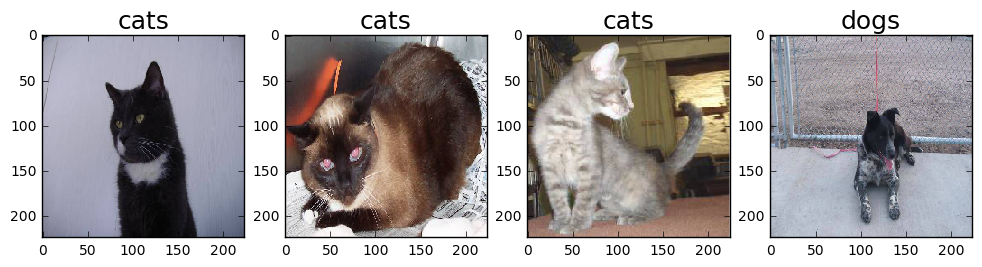

In [154]:
import numpy as np
from utils import plots

test_path = 'data/dogscats/test'
test_batches = image.ImageDataGenerator().flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    batch_size=4
)
imgs, labels = next(test_batches)

prediction = new_model.predict(imgs)
class_prediction = np.argmax(prediction, axis=1)

class_labels = {value: key for (key, value) in batches.class_indices.iteritems()}
predicted_labels = [class_labels[prediction] for prediction in class_prediction]

plots(imgs, titles=predicted_labels)